# Basic LangGrap app with chatbot and tool
* We will build a basic app that perform 4 operations that will remind ourselves about some of the things we did with LangChain in the Generative AI Bootcamp:
    * Use chat messages as state
    * Use chat model in node
    * Bind a tool to the chat model
    * Execute tool call in node

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 004-graph-with-chain.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]
os.environ["http_proxy"] = ""
os.environ["https_proxy"] = ""

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [2]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Building an app (called graph in langgraph) that chats with an LLM

* Here you have a graphic representation of the app we will build:

![Simple graph](graph002.png)

## Define the State schema

* For this example, our State class will be called MessagesState and is only going to have one key called "messages" with the format of a list of AnyMessages.
* When we run the app, we want to append messages to this messages state key. We wil use a **reducer function** for this.
* Reducer functions (often called simply reducers) allow us to specify how state updates are performed.
* If no reducer function is specified, then it is assumed that updates to the key should overwrite it as we saw in the previous exercise.
* To append messages, we can use the **pre-built add_messages reducer**. This ensures that any messages are appended to the existing list of messages.
* In order to do this, we need to annotate our messages key with the add_messages reducer function as metadata.

In [3]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In simple terms, this is what the previous code does:

#### Imports
   - `TypedDict` (from `typing_extensions`): This lets you define a dictionary with a specific structure, where each key has a predefined type.
   - `AnyMessage`: A module from `langchain_core.messages`.
   - `Annotated`: A feature from Python's `typing` module that allows attaching additional metadata or context to a type.
   - `add_messages`: A module from `langgraph.graph.message`.

#### Class Definition
   - `MessagesState` is a subclass of `TypedDict`. This means it represents a dictionary where the structure (keys and their corresponding types) is clearly defined.
   - In this case, the dictionary has one key:
     - **`messages`**: A list of `AnyMessage` objects.

#### Annotated Type
   - The type of `messages` is `Annotated[list[AnyMessage], add_messages]`.
   - This means:
     - The value of `messages` must be a list of `AnyMessage` objects.
     - The `add_messages` annotation provides additional functionality for this field. To append messages, we will use the pre-built add_messages reducer. This ensures that any messages are appended to the existing list of messages.

#### What is `Annotated`?

`Annotated` is a feature from Python's `typing` module. It lets you **attach extra metadata** or information to a type. This metadata can then be used by tools, libraries, or frameworks to influence how the type is interpreted or processed, without changing the core behavior of the type itself.

In simple terms:
- It’s a way to **add "extra notes" to a type** so other code or tools can use those notes to perform additional actions.

#### Syntax of `Annotated`:

```python
from typing import Annotated

# Basic example
x: Annotated[int, "This is metadata"]
```

- Here, `x` is an integer (`int`), but it has extra metadata (`"This is metadata"`) attached to it. Tools can use this metadata to add functionality, like validation or transformation.

#### How `Annotated` Works in the Previous Code:

```python
messages: Annotated[list[AnyMessage], add_messages]
```

- **The Core Type:** `list[AnyMessage]`
  - This means `messages` is a list containing `AnyMessage` objects.

- **The Annotation (`add_messages`):**
  - `add_messages` is additional information or logic attached to the `list[AnyMessage]`.
  - `add_messages` is a reducer function that provides custom behavior for this field, ensuring that any messages are appended to the existing list of messages.

#### Why Use `Annotated` Here?

In this context, `Annotated` is used to:
1. **Add Extra Behavior:** The `add_messages` annotation modifies how the `messages` list is processed.
2. **Keep the Code Clean:** Instead of modifying the core type (`list[AnyMessage]`), the annotation separates the additional logic (`add_messages`) from the basic type definition.
3. **Improve Flexibility:** Different tools or parts of the application can interpret or act on the `add_messages` annotation in specific ways.

## LangGraph has a simplified way to do this
* Since having a list of messages in graph state is so common, LangGraph has a **pre-built `MessagesState`** defined with a pre-built `messages` key which is a list of `AnyMessage` objects and it uses the `add_messages` reducer.

So, the default way of doing this in LangGraph is:

In [4]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

## Define the only Node of this app
* Nodes are defined as functions.
* The first argument in a Node function is the state. In this exercise each node can access the key `messages`, with `state['messages']`.
* In this example we only have one node.
* **See that we are using the chatModel4o we previously defined**. If you prefer it, you could use chatModel35 instead.

In [5]:
# Node with a chatbot
def simple_llm(state: MessagesState):
    return {"messages": [chatModel4o.invoke(state["messages"])]}

## Since in this example we only have one Node, we do not have to define edges.

## Build the app
* First, we initialize a StateGraph with the `MessagesState` class we defined above.
* Then, we add the only node.
* The `START` Node is a special node that sends user input to the graph, to indicate where to start our graph.
* The `END` Node is a special node that represents a terminal node.
* We compile our graph to perform a few basic checks on the graph structure.
* Finally, we visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

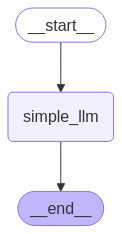

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Build graph
builder = StateGraph(MessagesState)

builder.add_node("simple_llm", simple_llm)

# Add the logic of the graph
builder.add_edge(START, "simple_llm")
builder.add_edge("simple_llm", END)

# Compile the graph
graph = builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

## Run the app
* The compiled graph implements the runnable protocol, a standard way to execute LangChain components. Because of that, we can use `invoke` as one of the standard methods to run this app.
* Our initial input is a dictionary `{"messages": HumanMessage(content="Where is the Golden Gate Bridge?")}`, which sets the initial value for the state dict.
* When `invoke` is called:
    * The graph starts execution from the `START` node.
    * It progresses through the defined node.
    * The execution continues until it reaches the `END` node.

In [7]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

# The following two lines are the most frequent way to 
# run and print a LangGraph chatbot-like app results.
messages = graph.invoke({"messages": HumanMessage(content="Where is the Golden Gate Bridge?")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Where is the Golden Gate Bridge?
================================== Ai Message ==================================

The Golden Gate Bridge is located in San Francisco, California, USA. It spans the Golden Gate Strait, the entrance to the San Francisco Bay from the Pacific Ocean, connecting the city of San Francisco to Marin County in the north.


* As you see, our app was able to chat with the LLM.

![Simple graph](graph002.png)

## Let's now add a tool to our ChatModel4o

In [8]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

chatModel4o_with_tools = chatModel4o.bind_tools([multiply])

## Let's now create a second LangGraph app that can decide if it uses the LLM chatbot or the Multiply Tool to respond to a user question

In [9]:
# Node
def llm_with_tool(state: MessagesState):
    return {"messages": [chatModel4o_with_tools.invoke(state["messages"])]}

printing graph


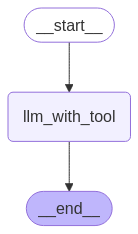

graph printed


In [14]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Build graph
builder = StateGraph(MessagesState)

builder.add_node("llm_with_tool", llm_with_tool)

# Add the logic of the graph
builder.add_edge(START, "llm_with_tool")
builder.add_edge("llm_with_tool", END)

# Compile the graph
graph = builder.compile()

print("printing graph")
os.environ["http_proxy"] = ""
os.environ["https_proxy"] = ""
# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))
print("graph printed")

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

# The following two lines are the most frequent way to 
# run and print a LangGraph chatbot-like app results.
messages = graph.invoke({"messages": HumanMessage(content="Where is the Eiffel Tower?")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Where is the Eiffel Tower?
================================== Ai Message ==================================

The Eiffel Tower is located in Paris, France. Specifically, it is situated on the Champ de Mars, a large public greenspace in the 7th arrondissement of Paris, near the Seine River.


In [16]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

# The following two lines are the most frequent way to 
# run and print a LangGraph chatbot-like app results.
messages = graph.invoke({"messages": HumanMessage(content="Multiply 4 and 5")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 4 and 5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Zp3iLQbCiFBiihUxCBwU66xc)
 Call ID: call_Zp3iLQbCiFBiihUxCBwU66xc
  Args:
    a: 4
    b: 5


#### This second app has agentic behavior
* Because depending on the input, the LLM decides which option to take:
    * Option A: respond with the LLM chatbot.
    * Option B: respond with the tool "Multiply".
* This is what is called "agentic behavior": the LLM makes some decisions by itself. 

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 004-graph-with-chain.py
* In terminal, make sure you are in the directory of the file and run:
    * python 004-graph-with-chain.py